In [11]:
#importing required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
#to plot within notebook
import matplotlib.pyplot as plt


from yahoo_fin import stock_info as si

def getpriceinfo(symbol):
    lp=si.get_live_price(symbol)

    
 
    #print(si.get_day_most_active())
 
    # get biggest gainers
    #print(si.get_day_gainers())
 
    # get worst performers
    #print(si.get_day_losers())
    return lp

def getqoutetable(symbol):
    

    qt=si.get_quote_table(symbol, dict_result = False)
 
    #print(si.get_day_most_active())
 
    # get biggest gainers
    #print(si.get_day_gainers())
 
    # get worst performers
    #print(si.get_day_losers())
    return qt

# function to calculate percentage difference considering baseValue as 100%
def percentageChange(baseValue, currentValue):
    return((float(currentValue)-baseValue) / abs(baseValue)) *100.00

# function to get the actual value using baseValue and percentage
def reversePercentageChange(baseValue, percentage):
    return float(baseValue) + float(baseValue * percentage / 100.00)

# function to transform a list of values into the list of percentages. For calculating percentages for each element in the list
# the base is always the previous element in the list.
def transformToPercentageChange(x):
    baseValue = x[0]
    x[0] = 0
    for i in range(1,len(x)):
        pChange = percentageChange(baseValue,x[i])
        baseValue = x[i]
        x[i] = pChange

# function to transform a list of percentages to the list of actual values. For calculating actual values for each element in the list
# the base is always the previous calculated element in the list.
def reverseTransformToPercentageChange(baseValue, x):
    x_transform = []
    for i in range(0,len(x)):
        value = reversePercentageChange(baseValue,x[i])
        baseValue = value
        x_transform.append(value)
    return x_transform

#read the data file
def predictpriceofdata(stockname):
    df = pd.read_csv('data\\'+stockname+'.csv')
# store the first element in the series as the base value for future use.
    baseValue = df['Close'][0]

# create a new dataframe which is then transformed into relative percentages
    data = df.sort_index(ascending=True, axis=0)
    new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
    for i in range(0,len(data)):
        new_data['Date'][i] = data['Date'][i]
        new_data['Close'][i] = data['Close'][i]

# transform the 'Close' series into relative percentages
    transformToPercentageChange(new_data['Close'])

# set Dat column as the index
    new_data.index = new_data.Date
    new_data.drop('Date', axis=1, inplace=True)

# create train and test sets
    dataset = new_data.values
    train, valid = train_test_split(dataset, train_size=0.99, test_size=0.01, shuffle=False)

# convert dataset into x_train and y_train.
# prediction_window_size is the size of days windows which will be considered for predicting a future value.
    prediction_window_size = 60
    x_train, y_train = [], []
    for i in range(prediction_window_size,len(train)):
        x_train.append(dataset[i-prediction_window_size:i,0])
        y_train.append(dataset[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

##################################################################################################
# create and fit the LSTM network
# Initialising the RNN
    model = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
    model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))

# Adding the output layer
    model.add(Dense(units = 1))
# Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
    model.fit(x_train, y_train, epochs = 1, batch_size = 1000)

##################################################################################################

#predicting future values, using past 60 from the train data
# for next 10 yrs total_prediction_days is set to 3650 days
    total_prediction_days = 3650
    inputs = new_data[-total_prediction_days:].values
    inputs = inputs.reshape(-1,1)

# create future predict list which is a two dimensional list of values.
# the first dimension is the total number of future days
# the second dimension is the list of values of prediction_window_size size
    X_predict = []
    for i in range(prediction_window_size,inputs.shape[0]):
        X_predict.append(inputs[i-prediction_window_size:i,0])
    X_predict = np.array(X_predict)

# predict the future
    X_predict = np.reshape(X_predict, (X_predict.shape[0],X_predict.shape[1],1))
    future_closing_price = model.predict(X_predict)

    train, valid = train_test_split(new_data, train_size=0.99, test_size=0.01, shuffle=False)
    date_index = pd.to_datetime(train.index)

#converting dates into number of days as dates cannot be passed directly to any regression model
    x_days = (date_index - pd.to_datetime('1970-01-01')).days

# we are doing prediction for next 5 years hence prediction_for_days is set to 1500 days.
    prediction_for_days = 300
    future_closing_price = future_closing_price[:prediction_for_days]

# create a data index for future dates
    x_predict_future_dates = np.asarray(pd.RangeIndex(start=x_days[-1] + 1, stop=x_days[-1] + 1 + (len(future_closing_price))))
    future_date_index = pd.to_datetime(x_predict_future_dates, origin='1970-01-01', unit='D')

# transform a list of relative percentages to the actual values
    train_transform = reverseTransformToPercentageChange(baseValue, train['Close'])

# for future dates the base value the the value of last element from the training set.
    baseValue = train_transform[-1]
    valid_transform = reverseTransformToPercentageChange(baseValue, valid['Close'])
    future_closing_price_transform = reverseTransformToPercentageChange(baseValue, future_closing_price)

# recession peak date is the date on which the index is at the bottom most position.
    recessionPeakDate =  future_date_index[future_closing_price_transform.index(min(future_closing_price_transform))]
    minCloseInFuture = min(future_closing_price_transform);
    print("The stock market will reach to its lowest bottom on", recessionPeakDate)
    print("The lowest index the stock market will fall to is ", minCloseInFuture)

# plot the graphs
    plt.figure(figsize=(16,8))
    df_x = pd.to_datetime(new_data.index)
    plt.plot(date_index,train_transform, label='Close Price History')
    plt.plot(future_date_index,future_closing_price_transform, label='Predicted Close')

# set the title of the graph
    plt.suptitle('Stock Market Predictions', fontsize=16)

# set the title of the graph window
    fig = plt.gcf()
    fig.canvas.set_window_title('Stock Market Predictions')

#display the legends
    plt.legend()

#display the graph
    plt.show()
    
    dictofdateandprice={}
    
    for i in range(38,50):
        dictofdateandprice[str(future_date_index[i])]=future_closing_price_transform[i]
    return dictofdateandprice

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [14/Sep/2020 19:04:24] "GET /null HTTP/1.1" 404 -
127.0.0.1 - - [14/Sep/2020 19:04:25] "GET /null HTTP/1.1" 404 -


GOOGL
[<a class="gnt_se_a gnt_se_a__hd gnt_se_a__hi" data-c-desc="The Federal Aviation Administration has approved Amazon's Prime Air service, which will use drones to deliver packages." data-t-l="|searchResults|Alphabet Inc Class A|3446544001|1" elementtiming="search-item-text" href="/story/tech/2020/08/31/amazon-prime-air-gets-faa-approval-drone-delivery-service/3446544001/">Amazon's Prime Air drone delivery service receives FAA approval<div class="gnt_se_th_by gnt_sbt gnt_sbt__ms gnt_sbt__ts" data-c-dt="Aug. 31, 2020" data-c-ms="TECH" style="--gnt-bc:#D34600">Brett Molina </div><img alt="" class="gnt_se_a_f" decoding="async" elementtiming="search-item-image" loading="eager" src="https://www.gannett-cdn.com/-mm-/0c5880b767471d05582025c1c7c95cff9a0cbe2c/c=0-4-1340-758/local/-/media/2019/11/23/USATODAY/usatsports/MotleyFool-TMOT-4079f754-amznprimeair.jpg?width=188&amp;height=106&amp;fit=crop&amp;format=pjpg&amp;auto=webp" srcset="https://www.gannett-cdn.com/-mm-/0c5880b767471d05582025c

127.0.0.1 - - [14/Sep/2020 19:04:27] "GET /searchforcompany?company=Alphabet+Inc+Class+A HTTP/1.1" 200 -



[<div class="gnt_pr"><form action="/search/" class="gnt_se_frm" role="search"><input aria-label="Search query" class="gnt_se_frm_q" enterkeyhint="search" mozactionhint="search" name="q" placeholder="Enter Search" value="Alphabet Inc Class A"/><button aria-label="Submit" class="gnt_se_frm_sm" data-t-l="${se}|searchbar|"><svg class="gnt_se_frm_sm_svg" viewbox="0 0 24 24"><path d="M15.75 14.33l4.96 4.96-1.42 1.42-4.96-4.96a6.5 6.5 0 1 1 1.41-1.41zM10.5 15a4.5 4.5 0 1 0 0-9 4.5 4.5 0 0 0 0 9z"></path></svg></button></form><a class="gnt_se_a gnt_se_a__hd gnt_se_a__hi" data-c-desc="The Federal Aviation Administration has approved Amazon's Prime Air service, which will use drones to deliver packages." data-t-l="|searchResults|Alphabet Inc Class A|3446544001|1" elementtiming="search-item-text" href="/story/tech/2020/08/31/amazon-prime-air-gets-faa-approval-drone-delivery-service/3446544001/">Amazon's Prime Air drone delivery service receives FAA approval<div class="gnt_se_th_by gnt_sbt gnt_sb

Epoch 1/1
2510/2510 [==============================] - 4s 2ms/step - loss: 2.5454
The stock market will reach to its lowest bottom on 2020-03-19 00:00:00
The lowest index the stock market will fall to is  1091.7177917957306


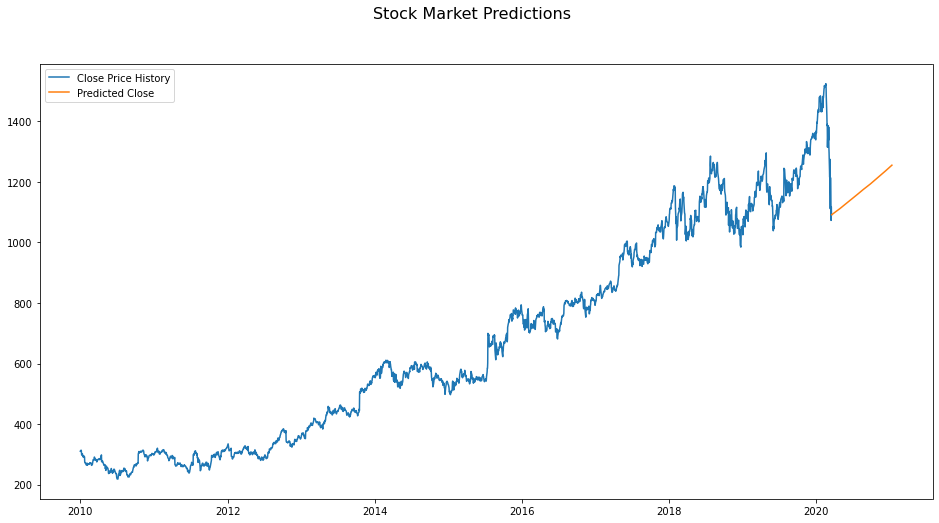

127.0.0.1 - - [14/Sep/2020 19:04:37] "GET /futurepriceprediction?msg=GOOGL HTTP/1.1" 200 -


{'2020-04-26 00:00:00': 1110.592284053564, '2020-04-27 00:00:00': 1111.0984545052052, '2020-04-28 00:00:00': 1111.608296662569, '2020-04-29 00:00:00': 1112.1227066218853, '2020-04-30 00:00:00': 1112.642839819193, '2020-05-01 00:00:00': 1113.1688969433308, '2020-05-02 00:00:00': 1113.6999567449093, '2020-05-03 00:00:00': 1114.2348978817463, '2020-05-04 00:00:00': 1114.7742093503475, '2020-05-05 00:00:00': 1115.3181408941746, '2020-05-06 00:00:00': 1115.8643044531345, '2020-05-07 00:00:00': 1116.4110910594463}


127.0.0.1 - - [14/Sep/2020 19:04:38] "GET /parsenews?msg=https%3A%2F%2Fwww.usatoday.com%2Fstory%2Ftech%2F2020%2F08%2F31%2Famazon-prime-air-gets-faa-approval-drone-delivery-service%2F3446544001%2F HTTP/1.1" 200 -


<a href='https://www.usatoday.com/story/tech/2020/08/31/amazon-prime-air-gets-faa-approval-drone-delivery-service/3446544001/' target="_blank" >https://www.usatoday.com/story/tech/2020/08/31/amazon-prime-air-gets-faa-approval-drone-delivery-service/3446544001/</a><br>
<a href='https://www.usatoday.com/story/tech/2020/08/31/amazon-prime-air-gets-faa-approval-drone-delivery-service/3446544001/' target="_blank" >https://www.usatoday.com/story/tech/2020/08/31/amazon-prime-air-gets-faa-approval-drone-delivery-service/3446544001/</a><br>Amazon customers in the U.S. could soon have their deliveries completed by an unmanned drone. The Federal Aviation Administration has approved Amazon's Prime Air service, which will use drones to deliver packages. The FAA issued a "Part 135 air carrier certificate using unmanned aircraft systems" to Amazon on Saturday, the agency confirmed in a statement to USA TODAY. Similar certificates have been issued to Wing Aviation, a subsidiary of Google parent compan

127.0.0.1 - - [14/Sep/2020 19:04:40] "GET /parsenews?msg=https%3A%2F%2Fwww.usatoday.com%2Fin-depth%2Fmoney%2Fbusiness%2F2020%2F08%2F20%2Fracism-black-america-corporate-america-facebook-apple-netflix-nike-diversity%2F5557003002%2F HTTP/1.1" 200 -


company for qoute GOOGL
<a href='https://www.usatoday.com/in-depth/money/business/2020/08/20/racism-black-america-corporate-america-facebook-apple-netflix-nike-diversity/5557003002/' target="_blank" >https://www.usatoday.com/in-depth/money/business/2020/08/20/racism-black-america-corporate-america-facebook-apple-netflix-nike-diversity/5557003002/</a><br>
<a href='https://www.usatoday.com/in-depth/money/business/2020/08/20/racism-black-america-corporate-america-facebook-apple-netflix-nike-diversity/5557003002/' target="_blank" >https://www.usatoday.com/in-depth/money/business/2020/08/20/racism-black-america-corporate-america-facebook-apple-netflix-nike-diversity/5557003002/</a><br>


127.0.0.1 - - [14/Sep/2020 19:04:40] "GET /fetchprice?msg=GOOGL HTTP/1.1" 200 -


price is
1526.1962890625


127.0.0.1 - - [14/Sep/2020 19:04:41] "GET /parsenews?msg=https%3A%2F%2Fwww.usatoday.com%2Fstory%2Ftech%2F2020%2F08%2F02%2Fgoogle-facebook-and-amazon-too-technical-congress-regulate%2F5547091002%2F HTTP/1.1" 200 -


<a href='https://www.usatoday.com/story/tech/2020/08/02/google-facebook-and-amazon-too-technical-congress-regulate/5547091002/' target="_blank" >https://www.usatoday.com/story/tech/2020/08/02/google-facebook-and-amazon-too-technical-congress-regulate/5547091002/</a><br>
<a href='https://www.usatoday.com/story/tech/2020/08/02/google-facebook-and-amazon-too-technical-congress-regulate/5547091002/' target="_blank" >https://www.usatoday.com/story/tech/2020/08/02/google-facebook-and-amazon-too-technical-congress-regulate/5547091002/</a><br>Many of us have had the feeling that technology, which continues to change at an ever-dizzying pace, may be leaving us behind. That was embodied this past week during a Congressional hearing, nominally convened to investigate antitrust concerns of four big tech titans: Amazon, Apple, Facebook and Google. While the five-and-a-half-hour inquiry touched on a range topics from pesky spam filters and search results to how companies approached acquisitions, the

In [ ]:
from flask import Flask
from flask import render_template,request
from datetime import time
import pandas as pd1
import requests
from bs4 import BeautifulSoup

from flask_jsonpify import jsonpify
import pandas as pd
import re
from datetime import datetime
from datetime import timedelta
import time
def fetchcurrentmarketprice(stock):
    stock1=stock
    #for ticker in ticker_list1:
    url = 'https://in.finance.yahoo.com/quote/' + stock1
    print(url)
    session = requests_html.HTMLSession()
    r = session.get(url)
    content = BeautifulSoup(r.content, 'html')
    try:
        price = str(content).split('data-reactid="32"')[4].split('</span>')[0].replace('>','')
        #print(str(content).split('data-reactid="47"'))
        openprice = str(content).split('data-reactid="49"')[3].split('</span>')[0].replace('>','')
        rangeobt = str(content).split('data-reactid="67"')[2].split('</span>')[0]
        #price = str(content).split('data-reactid="32"')[4].split('</span>')[0].replace('>','')
        #price = str(content).split('data-reactid="32"')[4].split('</span>')[0].replace('>','')
        #price = str(content).split('data-reactid="32"')[4].split('</span>')[0].replace('>','')
    except IndexError as e:
        price = 0.00
        price = price or "0"
    try:
        price = float(price.replace(',',''))
    except ValueError as e:
        price = 0.00
        time.sleep(1)
   
    print( price)
    print(openprice)
    print(rangeobt)
        #cursor.execute(_SQL, (unidecode.unidecode(ticker[0]), price, unidecode.unidecode(ticker[1]), unidecode.unidecode(ticker[2]), unidecode.unidecode(ticker[3])))
    return price



#urltofetch='https://www.usatoday.com/story/money/2020/04/22/amazon-doing-free-deliveries-food-banks-during-coronavirus-emergency/2997254001/'

#alldata=parsenews(urltofetch)
#print(alldata)

#Python program to scrape website  
#and save quotes from website 
import requests 
from bs4 import BeautifulSoup 
import csv 
import re

def callingnews(query):

    URL = "https://www.usatoday.com/search/?q="+query
    r = requests.get(URL) 
#print(r)
  
    soup = BeautifulSoup(r.content, 'html.parser') 
#print(soup)
    quotes=[]  # a list to store quotes 
  

    table1 = soup.find_all('a', attrs = {'class':'gnt_se_a gnt_se_a__hd gnt_se_a__hi'}) 
    print(table1)

#table13 = table11.get_text()
#print(table13) 

    table11 = soup.find_all('div', attrs = {'class':'gnt_pr'}) 
    print(table11)
    datalist=[]
    linksdata=[]
#print(table11)
    for ik in table11:
        datalist.append(ik.get_text())
        print(ik.get_text())

    pos=0
    listtocheck=[]
    for ik in table1:
        links = re.findall("href=[\"\'](.*?)[\"\']", str(ik))
        linksdata.append('https://www.usatoday.com'+links[0])
        if 'story' not in links[0]:
            listtocheck.append(pos)
        pos+=1
        print(links)

    print("list check is ",listtocheck)

    for ij in range(len(listtocheck)):
        print(ij)
        #datalist.pop(ij)
        #linksdata.pop(ij)
    #print(listtocheck[ij])

    print(len(datalist))
    print(len(linksdata))
    return datalist,linksdata


#df
df1=pd1.read_csv('fortune500.csv')
df=pd.DataFrame()
app = Flask(__name__)


@app.route("/parsenews")
def parsenews(): 
    newsinfo = request.args.get('msg')
    URL =newsinfo.rstrip().lstrip().strip()# "https://www.hindustantimes.com/delhi-news/protest-at-delhi-s-jama-masjid-against-citizenship-act-4-metro-stations-closed-in-area/story-q7vKj5IUdIKMExw5eGBfxI.html"
    #URL ="https://www.hindustantimes.com/delhi-news/protest-at-delhi-s-jama-masjid-against-citizenship-act-4-metro-stations-closed-in-area/story-q7vKj5IUdIKMExw5eGBfxI.html"
    #print repr(URL)
    r = requests.get(URL) 
    #print(r)
    soup = BeautifulSoup(r.content, 'html.parser') 
  
    quotes=[]  # a list to store quotes 
  
    table = soup.find('div', attrs = {'class':'gnt_ar_b'}) 
    #print(table)
    alltestdata='<a href=\''+URL+'\' target="_blank" >'+URL+'</a>'+'<br>'
    print(alltestdata)
    try:
        table1 = table.find_all('p')
        
        for row in table.find_all('p'):
            quote = {} 
            quote['data'] = row.text 
            alltestdata=alltestdata+row.text+" "
            quotes.append(quote)
    except:
        alltestdata='<a href=\''+URL+'\' target="_blank" >'+URL+'</a>'+'<br>'
    #print(alltestdata)
    print(alltestdata)
    return alltestdata

@app.route("/searchforcompany")
def searchforcompany():
    global df
    legend = 'Stock Price data'
    company = request.args.get('company')
    dfop=df1.loc[df1['Name'] == company]
    op1=str(dfop['Symbol'].iloc[0])
    print(op1)
    df=pd1.read_csv('data//'+op1+'.csv')
    temperatures = list(df['Close'])
    times = list(df['Date'])
    
    datalist,linksdata=callingnews(company)
    dictis={}
    for ims in range(len(linksdata)):
        dictis[linksdata[ims]]=linksdata[ims]
        
    print("dictionary is ",dictis)
    urlofsite='https://www.usatoday.com'
    io=0
    return render_template('line_chart.html',dictdata=dictis,links=linksdata,news=datalist, values=temperatures, labels=times, legend=legend,stockname=company,symbolis=op1)
    #return op1

@app.route("/futurepriceprediction")
def futurepriceprediction():
    companySymbol = request.args.get('msg')
    dictis=predictpriceofdata(companySymbol)
    #print('price is')
    print(dictis)
    #print(sendingcompaniesinfo)
    return dictis

    
    
@app.route("/fetchprice")
def fetchprice():
    company = request.args.get('msg')
    priceis=getpriceinfo(company)#'1211'#fetchcurrentmarketprice(company)
    print('price is')
    print(priceis)
    #print(sendingcompaniesinfo)
    return str(priceis)


@app.route("/getqoutetableval")
def getqoutetableval():
    company = request.args.get('msg')
    print('company for qoute '+company)
    qoute=getqoutetable(company)#'1211'#fetchcurrentmarketprice(company)
    print('qoute is')
    print(qoute)
    df_list = qoute.values.tolist()
    alldata=''
    for ik in range(len(df_list)):
        alldata=alldata+str(df_list[ik][0])+" :- "+str(df_list[ik][1])+"<br>\n"
    #JSONP_data = jsonpify(df_list)
    #print(sendingcompaniesinfo)
    return alldata

@app.route("/")
def index():
    temperatures = dict(df1['Name'])
    sendingcompaniesinfo={}
    for keys in temperatures: 
        temperatures[keys] = str(temperatures[keys]) 
        sendingcompaniesinfo[temperatures[keys]]='null'
    #print(sendingcompaniesinfo)
    return render_template('searching.html', values=sendingcompaniesinfo)




@app.route("/simple_chart")
def chart():
    legend = 'Monthly Data'
    labels = ["January", "February", "March", "April", "May", "June", "July", "August"]
    values = [10, 9, 8, 7, 6, 4, 7, 8]
    return render_template('chart.html', values=values, labels=labels, legend=legend)


@app.route("/line_chart")
def line_chart():
    legend = 'Temperatures'
    temperatures = list(df['Close'])
    times = list(df['Date'])
    return render_template('line_chart.html', values=temperatures, labels=times, legend=legend)

@app.route("/price")
def price():
    global df
    userText = request.args.get('msg')
    print(userText)
    op=dict(df.iloc[int(userText)])#tuple(list(df.iloc[int(userText)]))
    print(op)
    #for dicts in test_list: 
    for keys in op: 
        op[keys] = str(op[keys]) 
    return op

@app.route("/time_chart")
def time_chart():
    legend = 'Temperatures'
    temperatures = [73.7, 73.4, 73.8, 72.8, 68.7, 65.2,
                    61.8, 58.7, 58.2, 58.3, 60.5, 65.7,
                    70.2, 71.4, 71.2, 70.9, 71.3, 71.1]
    times = [time(hour=11, minute=14, second=15),
             time(hour=11, minute=14, second=30),
             time(hour=11, minute=14, second=45),
             time(hour=11, minute=15, second=00),
             time(hour=11, minute=15, second=15),
             time(hour=11, minute=15, second=30),
             time(hour=11, minute=15, second=45),
             time(hour=11, minute=16, second=00),
             time(hour=11, minute=16, second=15),
             time(hour=11, minute=16, second=30),
             time(hour=11, minute=16, second=45),
             time(hour=11, minute=17, second=00),
             time(hour=11, minute=17, second=15),
             time(hour=11, minute=17, second=30),
             time(hour=11, minute=17, second=45),
             time(hour=11, minute=18, second=00),
             time(hour=11, minute=18, second=15),
             time(hour=11, minute=18, second=30)]
    return render_template('time_chart.html', values=temperatures, labels=times, legend=legend)


if __name__ == "__main__":
    app.run('0.0.0.0')


In [20]:
from flask_jsonpify import jsonpify
qoute=getqoutetable('amzn')#'1211'#fetchcurrentmarketprice(company)
#print('qoute is')
#print(qoute)
df_list = qoute.values.tolist()
print(df_list)
print(df_list[0][0])
print(df_list[0][1])
print(df_list[1][0])
print(df_list[2][0])

alldata=''
for ik in range(len(df_list)):
    alldata=alldata+str(df_list[ik][0])+str(df_list[ik][1])+"\n"

print(alldata)


[['1y Target Est', 303.56], ['52 Week Range', '170.27 - 327.85'], ['Ask', '290.78 x 1400'], ['Avg. Volume', 50819157.0], ['Beta (5Y Monthly)', 1.17], ['Bid', '290.20 x 1200'], ["Day's Range", '285.85 - 299.00'], ['EPS (TTM)', 12.73], ['Earnings Date', 'Jul 28, 2020 - Aug 03, 2020'], ['Ex-Dividend Date', 'Feb 07, 2020'], ['Forward Dividend & Yield', '3.08 (1.05%)'], ['Market Cap', '1.265T'], ['Open', 286.25], ['PE Ratio (TTM)', 22.71], ['Previous Close', 293.8], ['Quote Price', 289.07000732421875], ['Volume', 60154175.0]]
1y Target Est
303.56
52 Week Range
Ask
1y Target Est303.56
52 Week Range170.27 - 327.85
Ask290.78 x 1400
Avg. Volume50819157.0
Beta (5Y Monthly)1.17
Bid290.20 x 1200
Day's Range285.85 - 299.00
EPS (TTM)12.73
Earnings DateJul 28, 2020 - Aug 03, 2020
Ex-Dividend DateFeb 07, 2020
Forward Dividend & Yield3.08 (1.05%)
Market Cap1.265T
Open286.25
PE Ratio (TTM)22.71
Previous Close293.8
Quote Price289.07000732421875
Volume60154175.0

